In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests, json
sns.set_style('whitegrid')

# US States

In [2]:
df_state_data = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')
df_state_data['date'] =  pd.to_datetime(df_state_data.date, format='%Y%m%d')
df_state_data.set_index(['date', 'state'], inplace=True)

states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

df_pop_raw = pd.read_csv('http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#')

res = requests.get('https://gist.githubusercontent.com/wavded/1250983/raw/bf7c1c08f7b1596ca10822baeb8049d7350b0a4b/stateCodeToFips.json')
j = json.loads(res.content)
df_fips = pd.DataFrame(list(j.items()), columns=['StateCode', 'FIPS'])
df_fips['FIPS'] = df_fips['FIPS'].astype(int)

df_pop = pd.merge(df_fips, df_pop_raw[['STATE', 'NAME', 'POPESTIMATE2019']], left_on='FIPS', right_on='STATE')
df_pop.set_index('StateCode', inplace=True)

In [3]:
dts = df_state_data.index.get_level_values('date').unique()
start_dt = pd.to_datetime('2/28/2020')
end_dt = dts.max()

Text(0.5, 0.98, 'Coronavirus: State Daily Increases in Positives, Hospitalizations, Deaths\nPer Million of Population, 7 Day Moving Average')

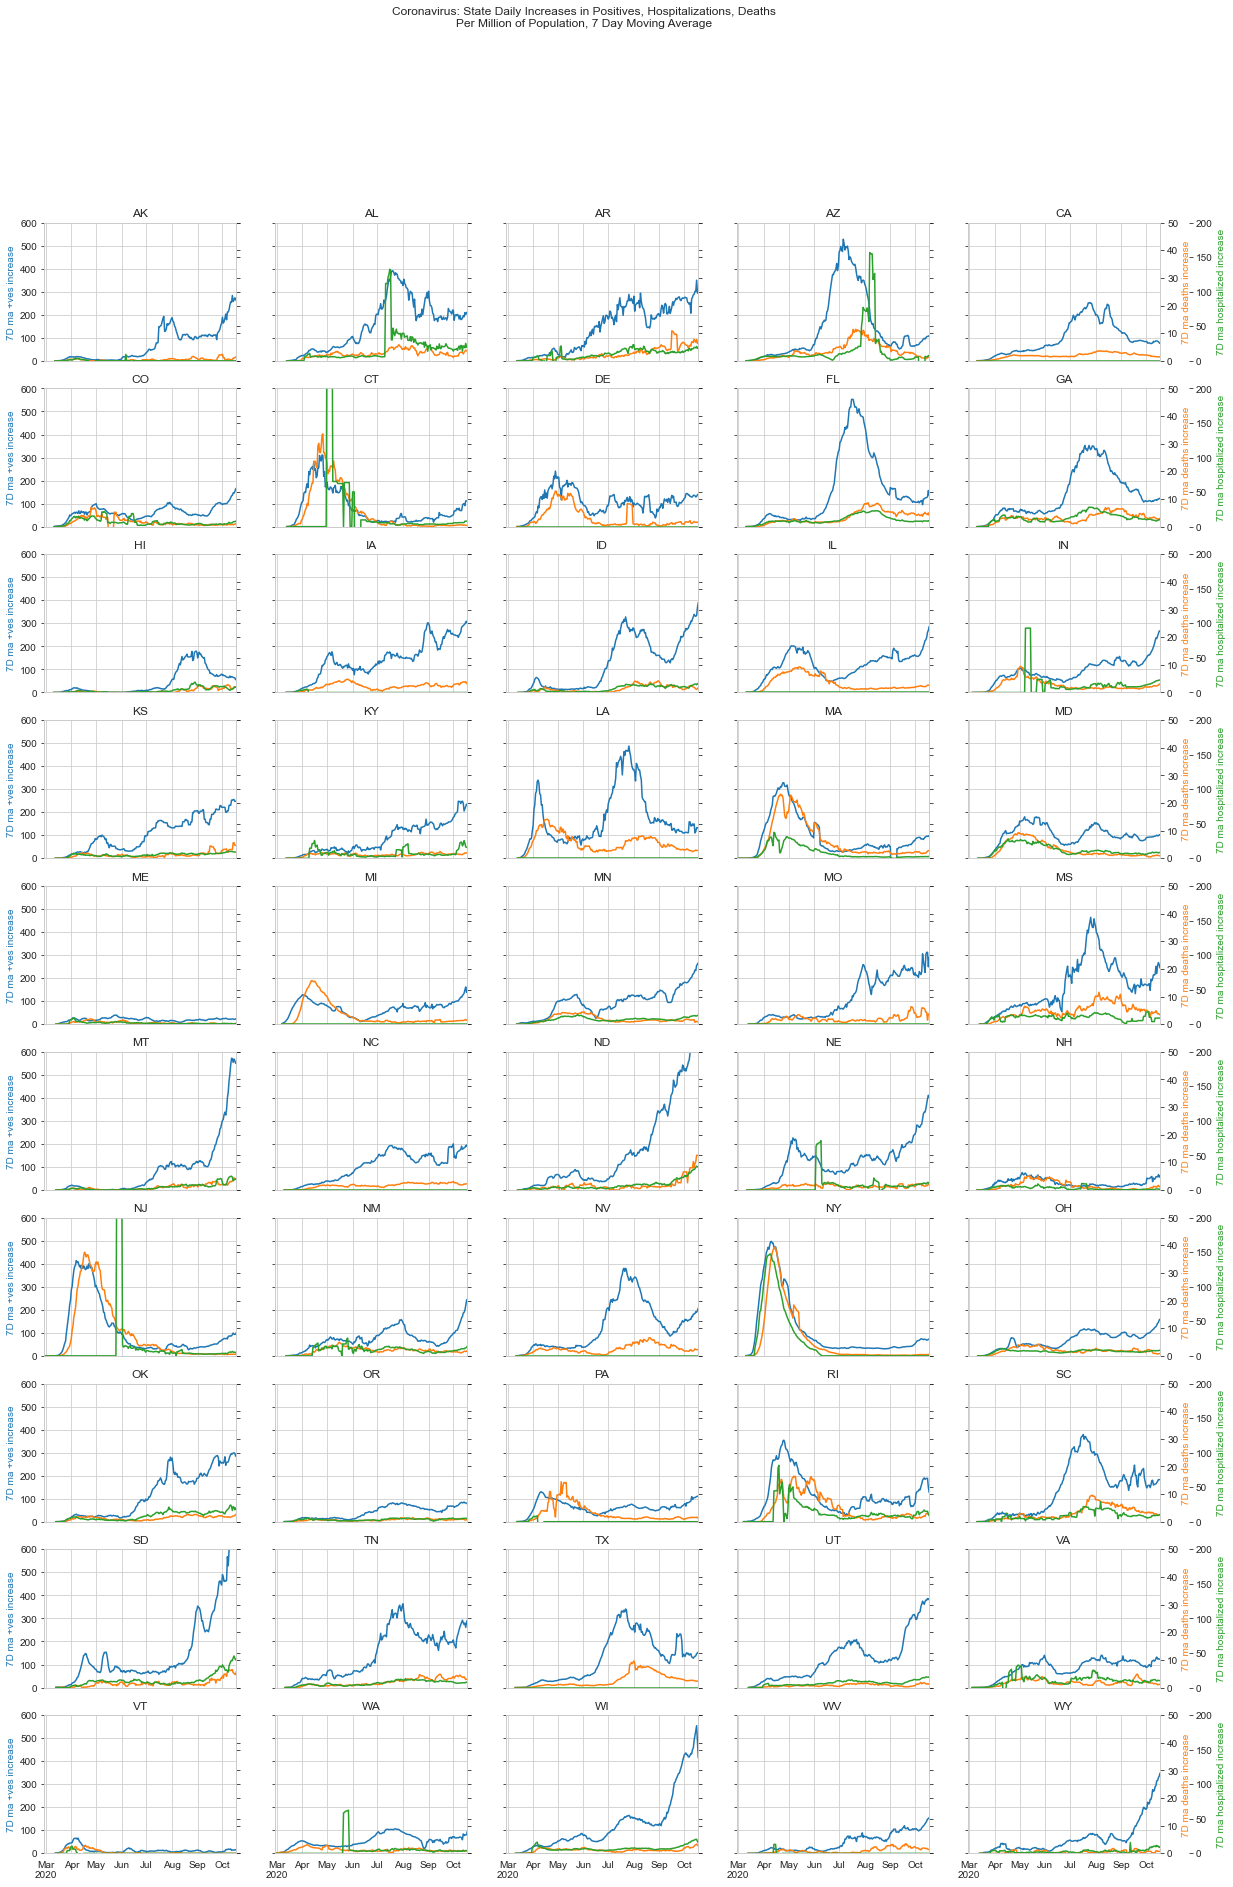

In [4]:
fig, axs = plt.subplots(10, 5, figsize=(20,30))

for i, state in enumerate(states):
    r, c = divmod(i, 5)
    ax1 = axs[r, c]
    
    df = df_state_data.xs(state, level=1).sort_index()[['positiveIncrease', 'hospitalizedIncrease', 'deathIncrease']]
    pop = df_pop.loc[state, 'POPESTIMATE2019'] / 1000000.
    
    ds1 = df.positiveIncrease.rolling(7).mean() / pop
    ds1.plot(ax=ax1, c=sns.color_palette()[0], label='7 day average increase in positives')
    ax1.set_xlim(start_dt, end_dt)
    ax1.set_ylim(0, 600)
    ax1.set_title(state)
    if c == 0:
        ax1.set_ylabel('7D ma +ves increase')
        ax1.yaxis.label.set_color(sns.color_palette()[0])
    else:
        ax1.set_yticklabels([])
    ax1.set_xlabel('')
    
    ax2 = ax1.twinx()
    ds2 = df.deathIncrease.rolling(7).mean() / pop
    ds2.plot(ax=ax2, c=sns.color_palette()[1], label='7 day average increase in deaths')
    ax2.set_xlim(start_dt, end_dt)
    ax2.set_ylim(0, 50)
    ax2.grid(False)
    if c == 4:
        ax2.set_ylabel('7D ma deaths increase')
        ax2.yaxis.label.set_color(sns.color_palette()[1])
    else:
        ax2.set_yticklabels([])
    ax2.set_xlabel('')
    
    ax3 = ax1.twinx()
    ds3 = df.hospitalizedIncrease.rolling(7).mean() / pop
    ds3.plot(ax=ax3, c=sns.color_palette()[2], label='7 day average increase in hospitalizations')
    ax3.set_xlim(start_dt, end_dt)
    ax3.set_ylim(0, 200)
    ax3.grid(False)
    if c == 4:
        ax3.set_ylabel('7D ma hospitalized increase')
        ax3.spines["right"].set_position(("axes", 1.15))
        ax3.set_frame_on(True)
        ax3.patch.set_visible(False)
        for sp in ax3.spines.values():
            sp.set_visible(False)
        ax3.yaxis.label.set_color(sns.color_palette()[2])
    else:
        ax3.set_yticklabels([])
    ax3.set_xlabel('')
    
    if r != 9:
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])
        
fig.suptitle('Coronavirus: State Daily Increases in Positives, Hospitalizations, Deaths\nPer Million of Population, 7 Day Moving Average')


# World plots

In [5]:
df_world_data0 = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [6]:
countries = ['CHN', 'IND', 'USA', 'IDN', 'PAK', 'BRA', 'RUS', 'MEX', 'JPN', 'TUR', 'DEU', 'GBR', 'FRA', 'ITA', 'KOR', 'COL', 'ESP', 'ARG', 'POL', 'CAN', 'SWE', 'NOR']
countries = sorted(countries)

In [7]:
df_world_data = df_world_data0.copy()
df_world_data['date'] = pd.to_datetime(df_world_data['date'])
df_world_data.set_index(['iso_code', 'date'], inplace=True)
df_world_data.sort_index(inplace=True)

In [8]:
dts = df_world_data.index.get_level_values('date').unique()
start_dt = pd.to_datetime('2/28/2020')
end_dt = dts.max()

Text(0.5, 0.98, 'Coronavirus: Country Daily Increases in Positives, Deaths\nPer Million of Population, 7 Day Moving Average')

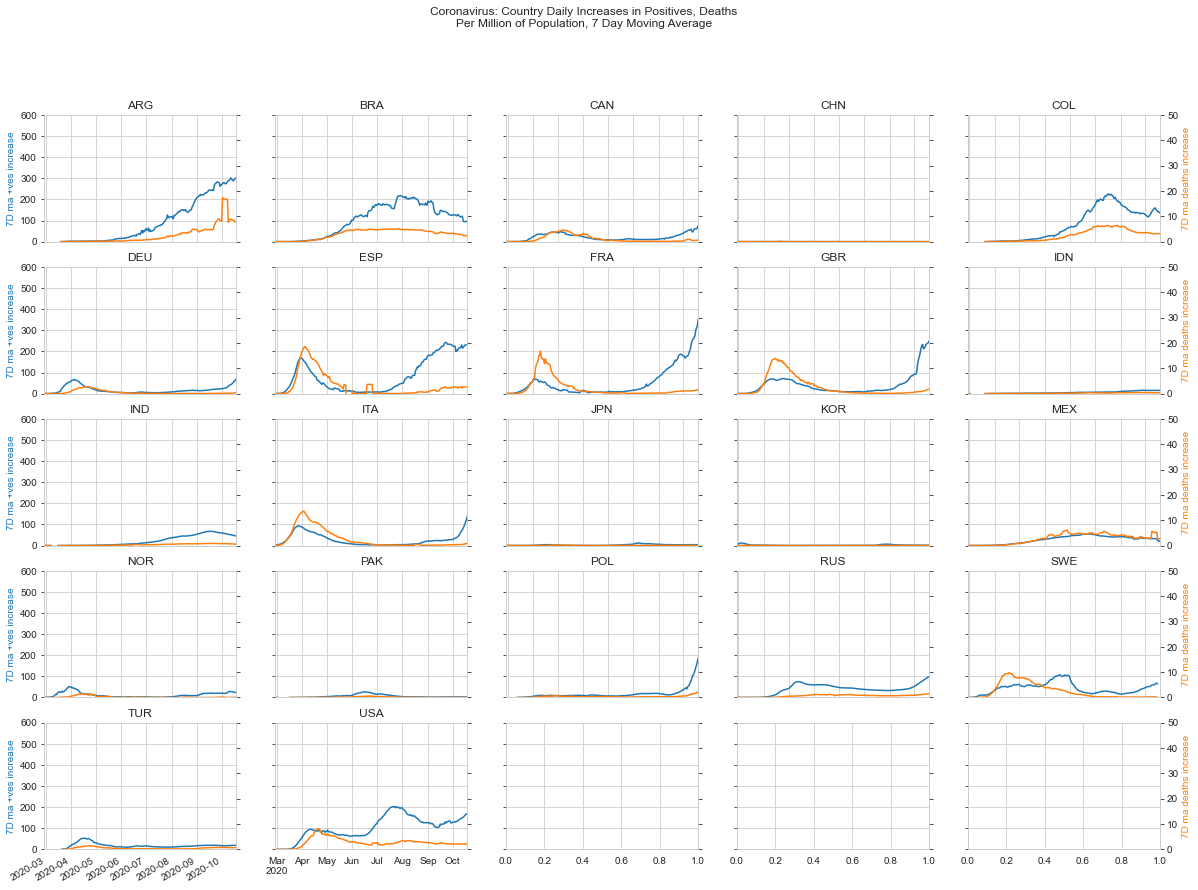

In [9]:
fig, axs = plt.subplots(5, 5, figsize=(20,15))

for i in range(axs.size):
    r, c = divmod(i, 5)
    ax1 = axs[r, c]
    ax2 = ax1.twinx()
    
    if i < len(countries):
        country = countries[i]

        df = df_world_data.xs(country, level='iso_code')

        ds1 = df.new_cases.rolling(7).mean() / (df.population / 1e6)
        ds1.plot(ax=ax1, c=sns.color_palette()[0], label='7 day average increase in positives')
        ax1.set_title(country)

        ds2 = df.new_deaths.rolling(7).mean() / (df.population / 1e6)
        ds2.plot(ax=ax2, c=sns.color_palette()[1], label='7 day average increase in deaths')

        ax1.set_xlim(start_dt, end_dt)
        ax2.set_xlim(start_dt, end_dt)

    ax1.set_ylim(0, 600)
    if c == 0:
        ax1.set_ylabel('7D ma +ves increase')
        ax1.yaxis.label.set_color(sns.color_palette()[0])
    else:
        ax1.set_yticklabels([])
    ax1.set_xlabel('')

    ax2.set_ylim(0, 50)
    ax2.grid(False)
    if c == 4:
        ax2.set_ylabel('7D ma deaths increase')
        ax2.yaxis.label.set_color(sns.color_palette()[1])
    else:
        ax2.set_yticklabels([])
    ax2.set_xlabel('')
    
    if r != 4:
        ax1.set_xticklabels([])
        ax2.set_xticklabels([])
        
fig.suptitle('Coronavirus: Country Daily Increases in Positives, Deaths\nPer Million of Population, 7 Day Moving Average')
